In [2]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [4]:
import os

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
path='/kaggle/input/ecg-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [7]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [8]:
Y.scp_codes.shape

(21799,)

In [9]:
X = load_raw_data(Y, sampling_rate, path)

In [10]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [14]:
X_train.shape

(19601, 1000, 12)

In [15]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [16]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [17]:
np.unique(y_train).shape[0]

25

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [19]:
y_train_encoded.shape

(19601, 5)

In [20]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
type(y_train_encoded)

pandas.core.frame.DataFrame

In [22]:
y_train_encoded['final_output']=y_train_encoded.apply(lambda x:''.join(x.astype(str)),axis=1)

In [23]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,00010
1,0,0,0,1,0,00010
2,0,0,0,1,0,00010
3,0,0,0,1,0,00010
4,0,0,0,1,0,00010


In [24]:
y_train_encoded['final_output'].nunique()

22

In [25]:
y_train_encoded['final_output'].unique()

array(['00010', '00100', '00000', '00001', '01000', '10000', '00101',
       '11000', '10100', '10001', '01100', '01101', '01001', '10101',
       '10010', '11101', '11001', '00011', '11100', '10011', '01010',
       '11110'], dtype=object)

In [26]:
def adjust_classes(y_train):
    var=y_train
    if var == '00010':
        var=0
    elif var == '00100':
        var =1
    elif var== '00000':
        var=2
    elif var=='00001':
        var =3
    elif var =='01000':
        var=4
    elif var=='10000':
        var =5
    elif var =='00101':
        var =6
    elif var =='11000':
        var=7
    elif var =='10100':
        var=8
    elif var=='10001':
        var =9
    elif var =='01100':
        var =10
    elif var =='01101':
        var =11
    elif var=='01001':
        var=21
    elif var =='10101':
        var=12
    elif var =='10010':
        var=13
    elif var=='11101':
        var=14
    elif var=='11001':
        var=15
    elif var =='00011':
        var=16
    elif var=='11100':
        var=17
    elif var=='10011':
        var=18
    elif var =='01010':
        var=19
    elif var=='11110':
        var=20
    return var

In [27]:
y_train_encoded['final_output']=y_train_encoded['final_output'].apply(adjust_classes)

In [28]:
y_train_encoded

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
19596,0,0,0,0,1,3
19597,0,0,0,1,0,0
19598,0,0,0,0,1,3
19599,0,0,0,1,0,0


In [29]:
y_train_encoded['final_output'].value_counts()

final_output
0     8157
1     2276
3     2158
5     1524
8     1164
21     708
6      538
4      479
9      433
2      371
13     362
11     320
7      273
12     202
15     186
10     166
14     140
17     112
16      24
18       5
19       2
20       1
Name: count, dtype: int64

In [31]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [32]:
x_train_normalization=X_train.reshape(-1,1000*12)

In [33]:
x_train=scaler.fit_transform(x_train_normalization)
x_train_normalized=x_train.reshape(19601,1000,12)

In [34]:
class_distribution_norm=y_train_encoded['NORM'].value_counts()

In [35]:
class_distribution_cd=y_train_encoded['CD'].value_counts()

In [36]:
class_distribution_hyp=y_train_encoded['HYP'].value_counts()

In [37]:
class_distribution_mi=y_train_encoded['MI'].value_counts()

In [38]:
class_distribution_sttc=y_train_encoded['STTC'].value_counts()

In [39]:
indices_0 = np.where(y_train_encoded['NORM'] == 0)[0] 
indices_1 = np.where(y_train_encoded['NORM'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


def build_train_and_evaluate_model(data_x, data_y, test_size=0.2, epochs=100, batch_size=32, val_split=0.2, patience=10):
   
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=test_size, random_state=42)

    # Ensure input data shape is correct
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    # Build the model
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(1000, 12), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(LSTM(100, return_sequences=False, dropout=0.4, recurrent_dropout=0.2))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Split training data for validation
    x_train_split, val_data, y_train_split, val_labels = train_test_split(
        x_train, y_train, test_size=val_split, random_state=42
    )

    # Train the model
    history = model.fit(
        x_train_split, y_train_split,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_labels),
        callbacks=[early_stopping]
    )

    # Evaluate on the test set
    print("Evaluating on test set:")
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Make predictions
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Recall and F1-Score
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\nRecall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"\nAUC-ROC: {roc_auc:.2f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return model, history


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.5797 - loss: 1.0572 - val_accuracy: 0.4953 - val_loss: 1.4618
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.7402 - loss: 0.8878 - val_accuracy: 0.5477 - val_loss: 1.5568
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.7854 - loss: 0.7824 - val_accuracy: 0.7047 - val_loss: 0.9826
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step - accuracy: 0.8151 - loss: 0.7123 - val_accuracy: 0.7758 - val_loss: 0.7745
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.8174 - loss: 0.6786 - val_accuracy: 0.8453 - val_loss: 0.6040
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.8286 - loss: 0.6365 - val_accuracy: 0.8297 - val_loss: 0.6099
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.8233 - loss: 0.6180 - val_accuracy: 0.8352 - val_loss: 0.5607
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.8417 -

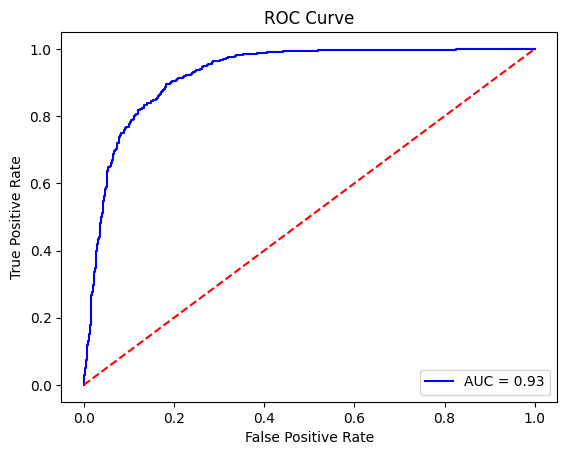

In [42]:
model, history = build_train_and_evaluate_model(x_train, y_train)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 32s 174ms/step - accuracy: 0.6671 - loss: 0.9902 - val_accuracy: 0.3172 - val_loss: 1.1509
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.7680 - loss: 0.8018 - val_accuracy: 0.4000 - val_loss: 1.1723
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.8072 - loss: 0.7107 - val_accuracy: 0.6922 - val_loss: 0.8354
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.8352 - loss: 0.6490 - val_accuracy: 0.7336 - val_loss: 0.7228
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.8326 - loss: 0.6015 - val_accuracy: 0.8516 - val_loss: 0.5606
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.8392 - loss: 0.5831 - val_accuracy: 0.8484 - val_loss: 0.5268
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.8453 - loss: 0.5293 - val_accuracy: 0.8047 - val_loss: 0.5548
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.8516 -

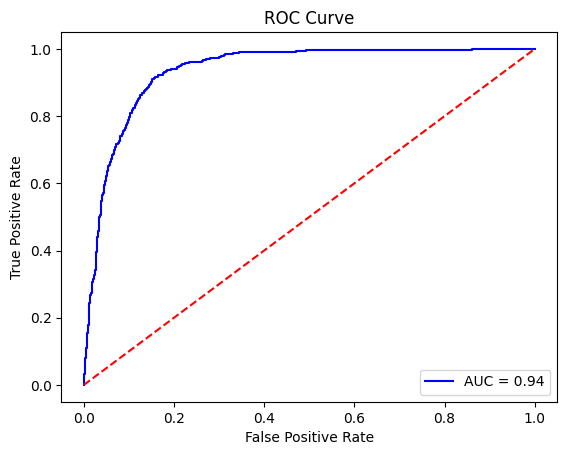

In [44]:
indices_0 = np.where(y_train_encoded['CD'] == 0)[0] 
indices_1 = np.where(y_train_encoded['CD'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
model, history = build_train_and_evaluate_model(x_train, y_train)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.7045 - loss: 0.9665 - val_accuracy: 0.3125 - val_loss: 1.2285
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.7761 - loss: 0.7922 - val_accuracy: 0.3875 - val_loss: 1.1666
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.8260 - loss: 0.6946 - val_accuracy: 0.7070 - val_loss: 0.8462
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8003 - loss: 0.6799 - val_accuracy: 0.8477 - val_loss: 0.5909
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.8556 - loss: 0.5994 - val_accuracy: 0.8156 - val_loss: 0.5953
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.8522 - loss: 0.5543 - val_accuracy: 0.8727 - val_loss: 0.5107
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.8563 - loss: 0.5377 - val_accuracy: 0.8328 - val_loss: 0.5352
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.8642 -

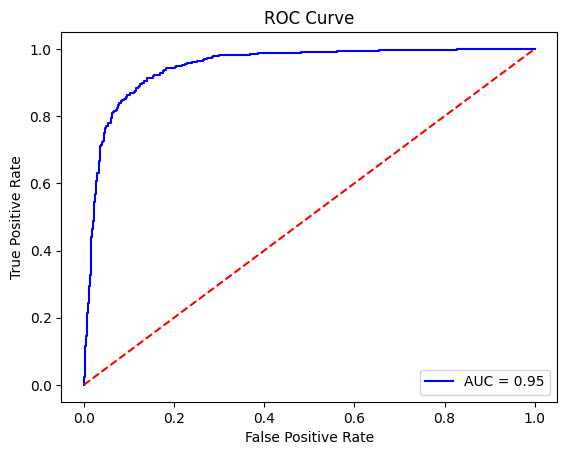

In [45]:
indices_0 = np.where(y_train_encoded['STTC'] == 0)[0] 
indices_1 = np.where(y_train_encoded['STTC'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
model, history = build_train_and_evaluate_model(x_train, y_train)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.6809 - loss: 0.9854 - val_accuracy: 0.3055 - val_loss: 1.3204
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.7741 - loss: 0.7915 - val_accuracy: 0.4609 - val_loss: 0.9915
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.8103 - loss: 0.7207 - val_accuracy: 0.7766 - val_loss: 0.7032
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.8074 - loss: 0.6643 - val_accuracy: 0.8094 - val_loss: 0.6357
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.8416 - loss: 0.6093 - val_accuracy: 0.8273 - val_loss: 0.5714
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.8429 - loss: 0.5805 - val_accuracy: 0.8320 - val_loss: 0.5567
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.8543 - loss: 0.5354 - val_accuracy: 0.8523 - val_loss: 0.5029
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.8486 -

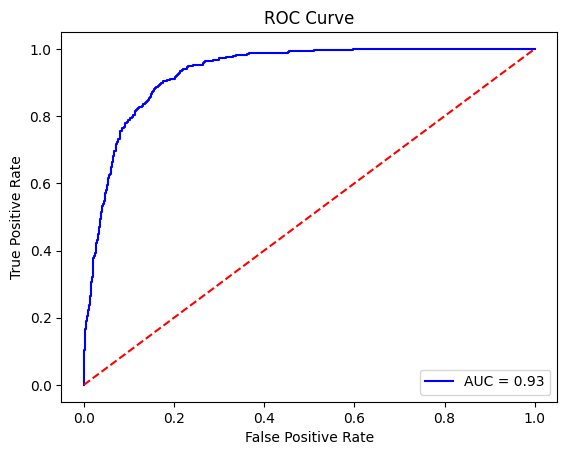

In [46]:
indices_0 = np.where(y_train_encoded['MI'] == 0)[0] 
indices_1 = np.where(y_train_encoded['MI'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
model, history = build_train_and_evaluate_model(x_train, y_train)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.7224 - loss: 0.9693 - val_accuracy: 0.2656 - val_loss: 1.1336
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.7745 - loss: 0.8309 - val_accuracy: 0.2609 - val_loss: 1.2619
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.8020 - loss: 0.7578 - val_accuracy: 0.6109 - val_loss: 0.9420
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.8049 - loss: 0.7180 - val_accuracy: 0.4000 - val_loss: 1.1642
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8440 - loss: 0.6583 - val_accuracy: 0.5000 - val_loss: 1.0826
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.8318 - loss: 0.6377 - val_accuracy: 0.6719 - val_loss: 0.8029
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8471 - loss: 0.5924 - val_accuracy: 0.8016 - val_loss: 0.6260
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.8467 - loss: 0.5807 - 

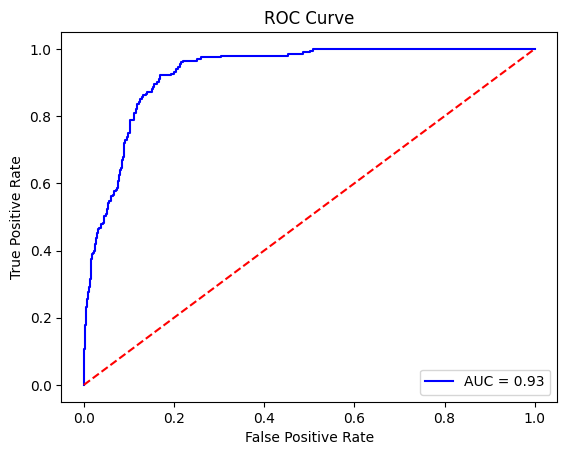

In [48]:
indices_0 = np.where(y_train_encoded['HYP'] == 0)[0] 
indices_1 = np.where(y_train_encoded['HYP'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 2000, replace=False)
selected_indices_1=np.random.choice(indices_1, 2000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
model, history = build_train_and_evaluate_model(x_train, y_train)
